## Setup

In [1]:
folder = "/Users/ckh/OneDrive - Default Directory/Hui_Wan/Meraub/"
# folder = "../data/Meraub"
shp = folder + "Meraub.shp"
tif = folder + "Meraub.tif"

In [2]:
from osgeo import ogr, osr, gdal
import os 
import numpy as np
import matplotlib.pyplot as plt

In [3]:
version_num = int(gdal.VersionInfo('VERSION_NUM'))
print(version_num)

def gdal_error_handler(err_class, err_num, err_msg):
    errtype = {
            gdal.CE_None:'None',
            gdal.CE_Debug:'Debug',
            gdal.CE_Warning:'Warning',
            gdal.CE_Failure:'Failure',
            gdal.CE_Fatal:'Fatal'
    }
    err_msg = err_msg.replace('\n',' ')
    err_class = errtype.get(err_class, 'None')
    print('Error Number: %s' % (err_num))
    print('Error Type: %s' % (err_class))
    print('Error Message: %s' % (err_msg))
    
## setup Error handler
gdal.PushErrorHandler(gdal_error_handler)
gdal.UseExceptions()

# ds = gdal.Open("some.tif")
ds = gdal.Open(tif)

# ## remove Error handler
# gdal.DontUseExceptions()
# gdal.PopErrorHandler()

3010000


In [4]:
def hint(obj):
    print("\n".join([i for i in dir(obj) if "_" not in i]))

## Read Shape File

In [5]:
driver = ogr.GetDriverByName('ESRI Shapefile')
dataSource = driver.Open(shp, 0)
layer = dataSource.GetLayer()


header = [s.GetName() for s in layer.schema]
rows = []
for f in layer:
    c = f.GetGeometryRef().GetPointCount()
#     print(f.GetGeometryRef().GetPoint())
    row = [f[h] for h in header]
#     print(row)
    rows.append(row)
    
dataSource.Release()

rows = np.array(rows)

In [6]:
print(header)
print(rows[0:2,:])

['ID', 'Lat', 'Long', 'pixH', 'pixW', 'yO', 'xO', 'scale', 'cls_pred', 'x1', 'y1', 'center_x', 'center_y']
[['0' '3.673066393968939' '101.8787457825044' '3.635650000000095e-07'
  '3.618840000001455e-07' '3.675469558618939' '101.8786571209244' '1'
  'MTL' '160' '6534' '245' '6610']
 ['1' '3.672966050028939' '101.8788804033524' '3.635650000000095e-07'
  '3.618840000001455e-07' '3.675469558618939' '101.8786571209244' '1'
  'MTL' '544' '6826' '617' '6886']]


## Plot shape file

Text(0.5, 1.0, 'Coordinates')

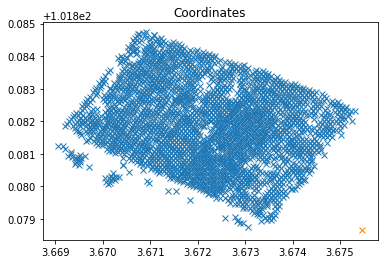

In [7]:
yO,xO = rows[0][5:7].astype(np.double)

lats = rows[:,1].astype(np.double)
longs = rows[:,2].astype(np.double)
plt.plot(lats, longs, 'x')
plt.plot([yO], [xO], 'x')

plt.title("Coordinates")

## Coordinate to Pixel


In [40]:
class Converter():
    def __init__(self, row):
        self.pixH, self.pixW = row[3:5].astype(np.double)
        self.yO,self.xO = row[5:7].astype(np.double)

    def c2p(self, long, lat):
        x = int((long - self.xO) / self.pixW + 0.5)
        y = int((self.yO - lat) / self.pixH + 0.5)
        return x,y
    
    def p2c(self, x, y):
        long  = self.xO + x*self.pixW
        lat = self.yO - y*self.pixH
        return long,lat
        
    def convert(self,row):
        debug = False
        lat, long = row[1:3].astype(np.double)
        c_x, c_y = row[11:13].astype(np.int)

        x,y = self.c2p(long, lat)
        err = x + y - c_x - c_y
        
        if debug:
            print("Converted: ", x ,y)
            print("Expected: ", c_x ,c_y)
            print("Error : ", x + y - c_x - c_y)
        return x,y, err
    

In [41]:
converter = Converter(rows[0])
pts = np.array([converter.convert(r) for r in rows])
print("error : ", sum(pts[:,2]))

error :  0


Text(0.5, 1.0, 'Raster Sapce')

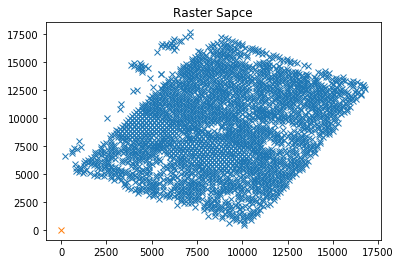

In [10]:
plt.plot(pts[:,0], pts[:,1], 'x')
plt.plot(0, 0, 'x')
plt.title("Raster Sapce")

## Read Tif File

In [26]:
src_ds = gdal.Open(tif)
print(src_ds.GetMetadata())
print("[ RASTER BAND COUNT ]: ", src_ds.RasterCount)
tifTransform = src_ds.GetGeoTransform()
print("[ Transform ]", tifTransform)
raw_img = src_ds.ReadAsArray()
print("[ Shape ]", raw_img.shape)

src_ds = None

{'AREA_OR_POINT': 'Area'}
[ RASTER BAND COUNT ]:  4
[ Transform ] (101.87865712092437, 3.6188400000014554e-07, 0.0, 3.6754695586189388, 0.0, -3.635650000000095e-07)
[ Shape ] (4, 18202, 17000)


In [12]:
img = raw_img.transpose((1,2,0))

In [13]:
# plt.imshow(img)

## VisualizeShape + Tif  

In [14]:
# plt.imshow(img)
# plt.plot(pts[:,0], pts[:,1], 'x')

## New Shape File

In [52]:
## Shape
## Layer
## Feture: Circle from center to x1,y1

# def CircleGeometry(c_x,c_y):
def toCircle(row):
    t_x, t_y = row[9:11].astype(np.double)
    c_x, c_y = row[11:13].astype(np.double)

    point_c = ogr.Geometry(ogr.wkbPoint)
    c_long, c_lat = converter.p2c(c_x, c_y)
    point_c.AddPoint(c_long, c_lat)

    t_long, t_lat = converter.p2c(t_x, t_y)
    point_t = ogr.Geometry(ogr.wkbPoint)
    point_t.AddPoint(t_long, t_lat)

    dist = point_c.Distance(point_t)
    circleBuf = point_c.Buffer(dist)
    circleRef = circleBuf.GetGeometryRef(0)
    circle = ogr.ForceToPolygon(circleRef)

    return circle

In [56]:
outDriver = ogr.GetDriverByName("ESRI Shapefile")
outShapefile = "circle.shp"
outDataSource = outDriver.CreateDataSource("circle.shp")
if os.path.exists(outShapefile):
    outDriver.DeleteDataSource(outShapefile)
    
srs = osr.SpatialReference()
srs.ImportFromEPSG(4326)

outLayer = outDataSource.CreateLayer("circle", srs, geom_type=ogr.wkbPolygon)

# Add an ID field - add field
idField = ogr.FieldDefn("id", ogr.OFTInteger)
outLayer.CreateField(idField)

# Create the feature and set values -- build up the data, geometry + field
for r in rows:
    uid = int(r[0])
    poly_circle = toCircle(r)
    
    featureDefn = outLayer.GetLayerDefn()
    feature = ogr.Feature(featureDefn)
    feature.SetGeometry(poly_circle)
    feature.SetField("id", uid)
    outLayer.CreateFeature(feature)
    feature = None
## save to file
outDataSource = None

## QGIS

![output example](./qgis_out.png)


![github img](https://github.com/ckhui/HelloGis/blob/master/qgis_out.png?raw=true)